# Chapter 17 - Representation Learning and Generative Learning using Autoencoders and GANs

## Efficient Data Representations (Autoencoders)

an autoencoder looks at the inputs, converts them to an efficient latent representation, and then spits out
something that (hopefully) looks very close to the inputs. An autoencoder is always composed of two parts: an encoder (or recognition network) that converts the inputs to a latent representation, followed by a decoder (or generative network) that converts the internal representation to the outputs (see Figure 17-1).

![autoencoder architecture](./images/ch17_autoencoder_architecture.png)

The architecture of an autoencoder is much like the same as a MLP, except that the number of neurons in the output layer must be equal the number of neurons in the input layer. Since the number of neurons in the hidden layer is less than the output layer, we say that this is an *undercomplete* autoencoder.

## Performing PCA with an Undercomplete Linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the mean
squared error (MSE), then it ends up performing Principal Component Analysis (PCA).

In [1]:
from tensorflow import keras

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

2022-06-01 11:42:44.279655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 11:42:44.279719: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-01 11:43:05.840876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 11:43:05.840969: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 11:43:05.841030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alexandre-Inspiron-5458): /proc/driver/nvidia/version does not exist
2022-06-01 11:43:05.851505: I tensorflow/core/platfor

Note that:

- We organized the autoencoder into two subcomponents: the encoder and the decoder. Both are regular Sequential models with a single Dense layer each, and the autoencoder is a Sequential model containing the encoder followed by the decoder (remember that a model can be used as a layer in another model).

- The autoencoder’s number of outputs is equal to the number of inputs (i.e., 3).

- To perform simple PCA, we do not use any activation function (i.e., all neurons are linear), and the cost function is the MSE. We will see more complex autoencoders shortly.

## Stacked Autoencoders

Autoencoders with more than one hidden layer are called *stacked autoencoders*. 

In [3]:
import numpy as np

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Implementing a Stacked Autoencoder Using Keras

In [4]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

/home/alexandre/git/handson-ml-notes/env-handsonml/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-06-01 20:21:19.681856: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2022-06-01 20:21:19.789570: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.3384 - val_loss: 0.3122
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3063 - val_loss: 0.3029
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2996 - val_loss: 0.2979
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2955 - val_loss: 0.2960
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2931 - val_loss: 0.2933
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2913 - val_loss: 0.2934
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2898 - val_loss: 0.2916
Epoch 8/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2886 - val_loss: 0.2891
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2875 - val_loss: 0.2881
Epoch 10/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.28

### Visualizing the Reconstructions

Matplotlib is building the font cache; this may take a moment.


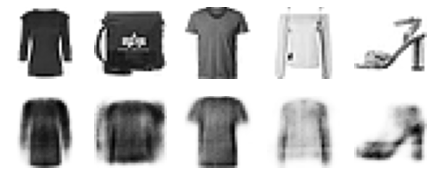

In [6]:
import matplotlib.pyplot as plt 

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(stacked_ae)

### Visualizing the Fashion MNIST Dataset

Using Autoencoders for dimensionality reduction may not be the best solution among other techniques when it comes to visualize the data in a lower dimension. However, one big advantage of Autoencoders is that they can handle large amounts of data with many features. So, one strategy is to reduce data dimensionality to a reasonable level, and then use another dimensionality reduction algorithm for visualization.

In [34]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

/home/alexandre/git/handson-ml-notes/env-handsonml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/alexandre/git/handson-ml-notes/env-handsonml/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


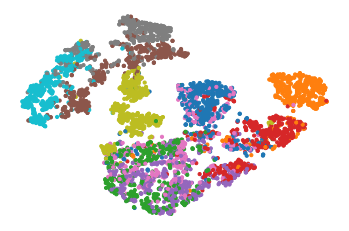

In [35]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

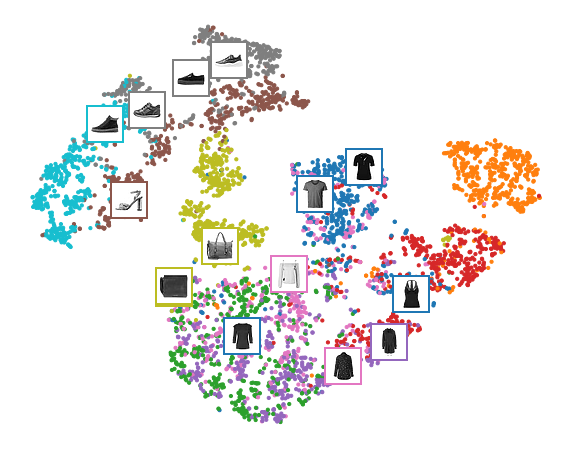

In [36]:
import matplotlib as mpl

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D[:15]):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

plt.show()

### Unsupervised Pretraining Using Stacked Autoencoders

If you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task and train it using the labeled data.

![Using Stacked AE for unsupervised Pretraining](./images/ch17_stacked_ae_unsupervised_pretraining.png)

There is nothing special about the implementation: just train an autoencoder
using all the training data (labeled plus unlabeled), then reuse its encoder layers
to create a new neural network.

### Tying weights

When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. By doing this, we are effectively reusing the weights from the encoder in the decoder.

This new model achieves a very slightly lower reconstruction error than the previous model, with almost half the number of parameters.

To tie weights between layers using Keras, let’s define a custom layer:

In [48]:
import tensorflow as tf

# acts like a dense layer but uses other layer's weights
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [50]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [51]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10


2022-06-01 21:00:52.652769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.
2022-06-01 21:00:52.761441: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 13s 7ms/step - loss: 0.3275 - rounded_accuracy: 0.8954 - val_loss: 0.3025 - val_rounded_accuracy: 0.9199
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2977 - rounded_accuracy: 0.9219 - val_loss: 0.2961 - val_rounded_accuracy: 0.9272
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2917 - rounded_accuracy: 0.9276 - val_loss: 0.2933 - val_rounded_accuracy: 0.9310
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2884 - rounded_accuracy: 0.9307 - val_loss: 0.2885 - val_rounded_accuracy: 0.9341
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2864 - rounded_accuracy: 0.9325 - val_loss: 0.2868 - val_rounded_accuracy: 0.9349
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2849 - rounded_accuracy: 0.9339 - val_loss: 0.2868 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [=======================

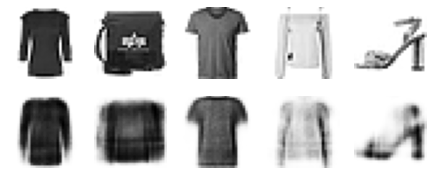

In [52]:
show_reconstructions(tied_ae)
plt.show()

### Training One Autoencoder at a Time

Rather than training the whole stacked autoencoder in one go like we just did, it
is possible to train one shallow autoencoder at a time, then stack all of them into
a single stacked autoencoder (hence the name), as shown in Figure 17-7. This
technique is not used as much these days, but you may still run into papers that
talk about “greedy layerwise training,” so it’s good to know what it means.

![Stack of Autoencoders](./images/ch17_stack_of_aes.png)

During the first phase of training, the first autoencoder learns to reconstruct the
inputs. Then we encode the whole training set using this first autoencoder, and
this gives us a new (compressed) training set. We then train a second
autoencoder on this new dataset. This is the second phase of training. Finally, we
build a big sandwich using all these autoencoders, as shown in Figure 17-7.

## Convolutional Autoencoders

We already know that convolutional networks are far better at dealing with image. The same applies to Autoencoders. But in this case, the encoder is a regular CNN composed of
convolutional layers and pooling layers. It typically reduces the spatial
dimensionality of the inputs (i.e., height and width) while increasing the depth
(i.e., the number of feature maps). The decoder must do the reverse (upscale the
image and reduce its depth back to the original dimensions), and for this you can
use transpose convolutional layers (alternatively, you could combine upsampling
layers with convolutional layers)

In [54]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5


2022-06-01 21:27:59.860019: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 59s 34ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2842 - val_rounded_accuracy: 0.9300
Epoch 2/5
1719/1719 [==============================] - 67s 39ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 50s 29ms/step - loss: 0.2708 - rounded_accuracy: 0.9461 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 54s 32ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2685 - val_rounded_accuracy: 0.9492
Epoch 5/5
1719/1719 [==============================] - 61s 36ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2672 - val_rounded_accuracy: 0.9507


## Recurrent Autoencoders

Similarly, we'd better off using Recurrent Autoencoders to deal with sequential data. Building a recurrent autoencoder is straightforward: the encoder is typically a
sequence-to-vector RNN which compresses the input sequence down to a single
vector. The decoder is a vector-to-sequence RNN that does the reverse:

In [55]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 135s 73ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 121s 70ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3740 - val_rounded_accuracy: 0.8672
Epoch 3/10
1719/1719 [==============================] - 104s 60ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3601 - val_rounded_accuracy: 0.8768
Epoch 4/10
1719/1719 [==============================] - 105s 61ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 105s 61ms/step - loss: 0.3406 - rounded_accuracy: 0.8874 - val_loss: 0.3361 - val_rounded_accuracy: 0.8918
Epoch 6/10
1719/1719 [==============================] - 113s 66ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3306 - val_rounded_accuracy: 0.8959
Epoch 7/10
1719/1719 [

This recurrent autoencoder can process sequences of any length, with 28
dimensions per time step. Conveniently, this means it can process Fashion
MNIST images by treating each image as a sequence of rows: at each time step,
the RNN will process a single row of 28 pixels. Note that we use a
RepeatVector layer as the first layer of the decoder, to ensure that its input
vector gets fed to the decoder at each time step.

## Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to
its inputs, training it to recover the original, noise-free inputs. The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout (introduced in Chapter 11). Figure 17-8 shows both options.

![Denoising Autoencoders](./images/ch17_denoising_autoencoders.png)

Using Gaussian Noise:

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9237
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [============

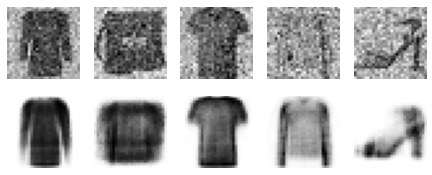

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [58]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3126 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [===============

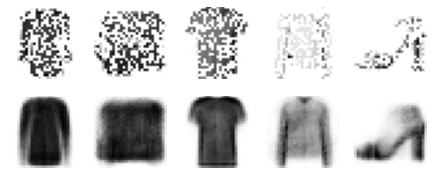

In [60]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

## Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is sparsity:
by adding an appropriate term to the cost function, the autoencoder is pushed to
reduce the number of active neurons in the coding layer. For example, it may be
pushed to have on average only 5% significantly active neurons in the coding
layer. This forces the autoencoder to represent each input as a combination of a
small number of activations. As a result, each neuron in the coding layer
typically ends up representing a useful feature.

There are two common approaches to develop Sparse Autoencoders: 

1. **Using a sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some ℓ regularization to the coding layer's activations (the decoder is just a regular decoder)**

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8991
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [===============

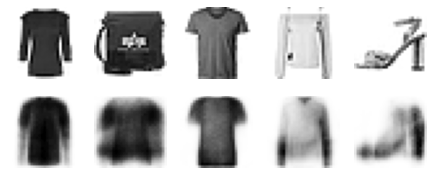

In [62]:
show_reconstructions(simple_ae)
plt.show()

This ActivityRegularization layer just returns its inputs, but as a side effect
it adds a training loss equal to the sum of absolute values of its inputs (this layer
only has an effect during training). Equivalently, you could remove the
`ActivityRegularization` layer and set
`activity_regularizer=keras.regularizers.l1(1e-3)` in the previous
layer. This penalty will encourage the neural network to produce codings close
to 0, but since it will also be penalized if it does not reconstruct the inputs
correctly, it will have to output at least a few nonzero values. Using the $\ell_1$ norm
rather than the $\ell_2$ norm will push the neural network to preserve the most
important codings while eliminating the ones that are not needed for the input
image (rather than just reducing all codings).

2. **Another approach, which often yields better results, is to measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparsity differs from a target sparsity. We use the Kullback Leibler divergence for that and incorporate a term for it in the model loss function.**

In our case, we want to measure the divergence between the target probability $p$
that a neuron in the coding layer will activate and the actual probability $q$ (i.e.,
the mean activation over the training batch)

$$
D_{KL}(p || q) = p \log{\frac{p}{q}} + (1-p)\log{\frac{1-p}{1-q}}
$$

Once we have computed the sparsity loss for each neuron in the coding layer, we
sum up these losses and add the result to the cost function. In order to control the
relative importance of the sparsity loss and the reconstruction loss, we can
multiply the sparsity loss by a sparsity weight hyperparameter. If this weight is
too high, the model will stick closely to the target sparsity, but it may not
reconstruct the inputs properly, making the model useless. Conversely, if it is too
low, the model will mostly ignore the sparsity objective and will not learn any
interesting features.

First, let’s create a custom regularizer to apply KL divergence regularization:

In [63]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now we can build the sparse autoencoder, using the `KLDivergenceRegularizer` for the coding layer’s activations:

In [64]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [============

## Variational Autoencoders